In [1]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
# Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

The following code cell imports the .csv file into a pandas DataFrame and scales the values in the label (median_house_value):

In [3]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
training_df["median_house_value"] /= 1000.0
# this means "training_df["median_house_value"] = training_df["median_house_value"]/1000.0"

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


## Examine the dataset

A large part of most machine learning projects is getting to know your data. The pandas API provides a `describe` function that outputs the following statistics about every column in the DataFrame:

* `count`, which is the number of rows in that column. Ideally, `count` contains the same value for every column. 

* `mean` and `std`, which contain the mean and standard deviation of the values in each column. 

* `min` and `max`, which contain the lowest and highest values in each column.

* `25%`, `50%`, `75%`, which contain various [quantiles](https://developers.google.com/machine-learning/glossary/#quantile).

In [4]:
# Get statistics on the dataset.
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


#@title Double-click to view a possible answer.

# The maximum value (max) of several columns seems very
# high compared to the other quantiles. For example,
# example the total_rooms column. Given the quantile
# values (25%, 50%, and 75%), you might expect the 
# max value of total_rooms to be approximately 
# 5,000 or possibly 10,000. However, the max value 
# is actually 37,937.

# When you see anomalies in a column, become more careful
# about using that column as a feature. That said,
# anomalies in potential features sometimes mirror 
# anomalies in the label, which could make the column 
# be (or seem to be) a powerful feature.
# Also, as you will see later in the course, you 
# might be able to represent (pre-process) raw data 
# in order to make columns into useful features.

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [5]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined the create_model and traing_model functions.")

Defined the create_model and traing_model functions.


## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [6]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


Train on 17000 samples
Epoch 1/30
17000/17000 [==============================] - 2s 117us/sample - loss: 2297061.4341 - root_mean_squared_error: 1515.6053 - loss: 7500699.9168 - 
Epoch 2/30
17000/17000 [==============================] - 1s 72us/sample - loss: 27862.6950 - root_mean_squared_error: 166.92120s - loss: 27803.3715 - root_mean_squared_error: 166.74
Epoch 3/30
17000/17000 [==============================] - 1s 71us/sample - loss: 26996.9352 - root_mean_squared_error: 164.3074
Epoch 4/30
17000/17000 [==============================] - 1s 69us/sample - loss: 26099.5653 - root_mean_squared_error: 161.5536
Epoch 5/30
17000/17000 [==============================] - 1s 71us/sample - loss: 25461.4914 - root_mean_squared_error: 159.5666
Epoch 6/30
17000/17000 [==============================] - 1s 71us/sample - loss: 24839.2226 - root_mean_squared_error: 157.6046
Epoch 7/30
17000/17000 [==============================] - 1s 70us/sample - loss: 24210.7500 - root_mean_squared_error: 155.598

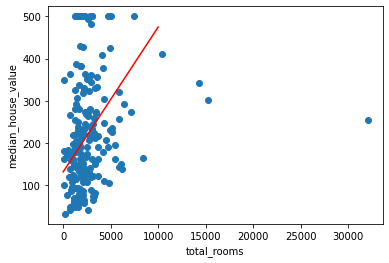

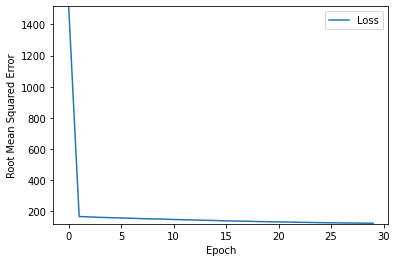

In [7]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
my_feature = "total_rooms"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on total_rooms.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight) # %.4f just means 4 decimal places after the float
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [8]:
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = training_df[feature][10000:10000 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_values[i][0] ))

Now, invoke the house prediction function on 10 examples:

In [9]:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1960     53             199
 3400     92             249
 3677     69             258
 2202     62             208
 2403     80             215
 5652    295             326
 3318    500             246
 2552    342             220
 1364    118             179
 3468    128             251


In [10]:
# TASK 2 JUDGE THE PREDICTIVE POWER OF THE MODEL
# Double-click to view the answer.

# Most of the predicted values differ significantly
# from the label value, so the trained model probably 
# doesn't have much predictive power. However, the
# first 10 examples might not be representative of 
# the rest of the examples.  

## Task 3: Try a different feature

The `total_rooms` feature had only a little predictive power. Would a different feature have greater predictive power?  Try using `population` as the feature instead of `total_rooms`. 

Note: When you change features, you might also need to change the hyperparameters.

Train on 17000 samples
Epoch 1/3
17000/17000 [==============================] - 1s 59us/sample - loss: 3618013.4294 - root_mean_squared_error: 1902.1075
Epoch 2/3
17000/17000 [==============================] - 0s 18us/sample - loss: 3675965.8771 - root_mean_squared_error: 1917.2808
Epoch 3/3
17000/17000 [==============================] - 0s 26us/sample - loss: 2959421.9057 - root_mean_squared_error: 1720.2971


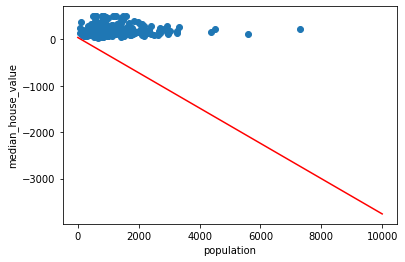

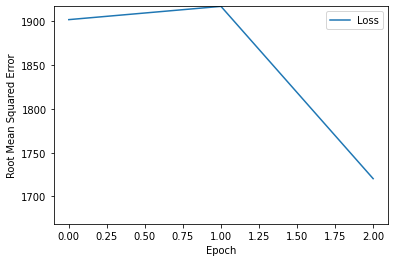

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1286     53            -448
 1867     92            -669
 2191     69            -792
 1052     62            -359
 1647     80            -585
 2312    295            -838
 1604    500            -569
 1066    342            -364
  338    118             -87
 1604    128            -569
 1200    187            -415
  292     80             -70
 2014    112            -725
 1817     95            -650
 1328     69            -464


In [11]:
my_feature = "population"   # Replace the ? with population or possibly
                   # a different column name.

# Experiment with the hyperparameters.
learning_rate = 2
epochs = 3
batch_size = 120

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

Train on 17000 samples
Epoch 1/18
17000/17000 [==============================] - 12s 730us/sample - loss: 28252.5642 - root_mean_squared_error: 168.0850
Epoch 2/18
17000/17000 [==============================] - 12s 702us/sample - loss: 19487.9385 - root_mean_squared_error: 139.5993
Epoch 3/18
17000/17000 [==============================] - 12s 698us/sample - loss: 18154.8970 - root_mean_squared_error: 134.7401
Epoch 4/18
17000/17000 [==============================] - 12s 706us/sample - loss: 18015.5294 - root_mean_squared_error: 134.2220
Epoch 5/18
17000/17000 [==============================] - 12s 731us/sample - loss: 18289.3653 - root_mean_squared_error: 135.2381 - loss: 18255.0218 - root_
Epoch 6/18
17000/17000 [==============================] - 12s 722us/sample - loss: 18074.9274 - root_mean_squared_error: 134.4432
Epoch 7/18
17000/17000 [==============================] - 13s 745us/sample - loss: 17937.1050 - root_mean_squared_error: 133.9293
Epoch 8/18
17000/17000 [================

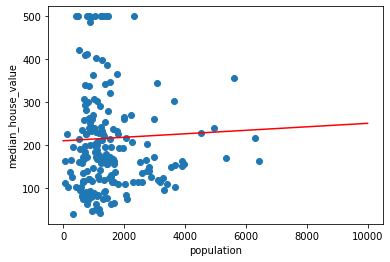

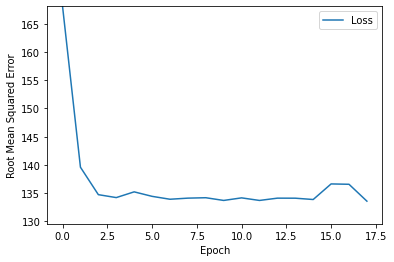

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1286     53             215
 1867     92             218
 2191     69             219
 1052     62             214
 1647     80             217
 2312    295             220
 1604    500             217
 1066    342             215
  338    118             212
 1604    128             217


In [12]:
#@title Double-click to view a possible solution.

my_feature = "population" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 18
batch_size = 3

# Don't change anything below.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(10, my_feature, my_label)

#@title Double-click to view the answer.

# Training is not entirely deterministic, but population 
# typically converges at a slightly higher RMSE than 
# total_rooms.  So, population appears to be about 
# the same or slightly worse at making predictions 
# than total_rooms.

## Task 4: Define a synthetic feature

You have determined that `total_rooms` and `population` were not useful features.  That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the *ratio* of `total_rooms` to `population` might have some predictive power. That is, perhaps block density relates to median house value.

To explore this hypothesis, do the following: 

1. Create a [synthetic feature](https://developers.google.com/machine-learning/glossary/#synthetic_feature) that's a ratio of `total_rooms` to `population`. (If you are new to pandas DataFrames, please study the [Pandas DataFrame Ultraquick Tutorial](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en).)
2. Tune the three hyperparameters.
3. Determine whether this synthetic feature produces 
   a lower loss value than any of the single features you 
   tried earlier in this exercise.

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 8s 489us/sample - loss: 15723.7868 - root_mean_squared_error: 125.3945
Epoch 2/20
17000/17000 [==============================] - 8s 491us/sample - loss: 14700.3443 - root_mean_squared_error: 121.2449
Epoch 3/20
17000/17000 [==============================] - 7s 416us/sample - loss: 14524.3955 - root_mean_squared_error: 120.5171s - loss: 14025.5741 - root_mean_squa
Epoch 4/20
17000/17000 [==============================] - 7s 435us/sample - loss: 14460.0818 - root_mean_squared_error: 120.2501
Epoch 5/20
17000/17000 [==============================] - 10s 564us/sample - loss: 14396.9220 - root_mean_squared_error: 119.9872
Epoch 6/20
17000/17000 [==============================] - 8s 467us/sample - loss: 14783.6842 - root_mean_squared_error: 121.5882
Epoch 7/20
17000/17000 [==============================] - 8s 446us/sample - loss: 14566.1842 - root_mean_squared_error: 120.6904
Epoch 8/20
17000/17000 [============

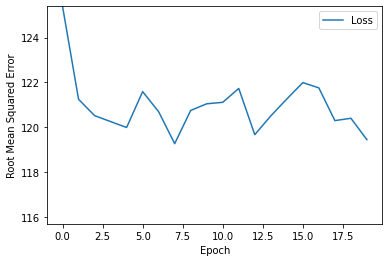

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             177
    2     92             193
    2     69             185
    2     62             208
    1     80             173
    2    295             228
    2    500             207
    2    342             225
    4    118             317
    2    128             212
    2    187             227
    3     80             241
    2    112             228
    2     95             220
    2     69             207


In [13]:
# Define a synthetic feature named rooms_per_person
training_df["rooms_per_person"] = training_df["total_rooms"]/training_df["population"] # write your code here.

# Don't change the next line.
my_feature = "rooms_per_person"

# Assign values to these three hyperparameters.
learning_rate = .5
epochs = 20
batch_size = 5

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

Train on 17000 samples
Epoch 1/24
17000/17000 [==============================] - 2s 100us/sample - loss: 38830.2801 - root_mean_squared_error: 197.0540
Epoch 2/24
17000/17000 [==============================] - 1s 62us/sample - loss: 19298.1656 - root_mean_squared_error: 138.9178
Epoch 3/24
17000/17000 [==============================] - 1s 62us/sample - loss: 15028.9877 - root_mean_squared_error: 122.5928
Epoch 4/24
17000/17000 [==============================] - 1s 63us/sample - loss: 14785.0075 - root_mean_squared_error: 121.5936
Epoch 5/24
17000/17000 [==============================] - 1s 70us/sample - loss: 14566.7431 - root_mean_squared_error: 120.6928
Epoch 6/24
17000/17000 [==============================] - 1s 78us/sample - loss: 14372.5011 - root_mean_squared_error: 119.8854
Epoch 7/24
17000/17000 [==============================] - 1s 72us/sample - loss: 14203.3349 - root_mean_squared_error: 119.1777
Epoch 8/24
17000/17000 [==============================] - 1s 78us/sample - loss:

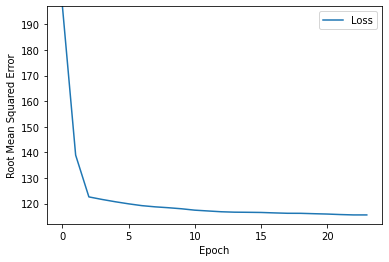

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             190
    2     92             201
    2     69             196
    2     62             212
    1     80             187
    2    295             226
    2    500             211
    2    342             224
    4    118             288
    2    128             215
    2    187             225
    3     80             235
    2    112             225
    2     95             220
    2     69             211


In [14]:
#@title Double-click to view a possible solution to Task 4.

# Define a synthetic feature
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
my_feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)


Based on the loss values, this synthetic feature produces a better model than the individual features you tried in Task 2 and Task 3. However, the model still isn't creating great predictions.

## Task 5. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two column's [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [15]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0


The correlation matrix shows nine potential features (including a synthetic
feature) and one label (`median_house_value`).  A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.  

**Your Task:** Determine which of the nine potential features appears to be the best candidate for a feature?

In [16]:
#@title Double-click here for the solution to Task 5

# The `median_income` correlates 0.7 with the label 
# (median_house_value), so median_income` might be a 
# good feature. The other seven potential features
# all have a correlation relatively close to 0. 

# If time permits, try median_income as the feature
# and see whether the model improves.

Correlation matrices don't tell the entire story. In later exercises, you'll find additional ways to unlock predictive power from potential features.

**Note:** Using `median_income` as a feature may raise some ethical and fairness
issues. Towards the end of the course, we'll explore ethical and fairness issues.

Train on 17000 samples
Epoch 1/24
17000/17000 [==============================] - 2s 143us/sample - loss: 25335.3097 - root_mean_squared_error: 159.1707
Epoch 2/24
17000/17000 [==============================] - 1s 70us/sample - loss: 7176.0613 - root_mean_squared_error: 84.7116
Epoch 3/24
17000/17000 [==============================] - 1s 77us/sample - loss: 7015.4838 - root_mean_squared_error: 83.7585
Epoch 4/24
17000/17000 [==============================] - 2s 100us/sample - loss: 7016.2151 - root_mean_squared_error: 83.7628
Epoch 5/24
17000/17000 [==============================] - 1s 83us/sample - loss: 7012.3431 - root_mean_squared_error: 83.7397
Epoch 6/24
17000/17000 [==============================] - 1s 78us/sample - loss: 7016.9367 - root_mean_squared_error: 83.7672
Epoch 7/24
17000/17000 [==============================] - 1s 81us/sample - loss: 7016.1306 - root_mean_squared_error: 83.7623
Epoch 8/24
17000/17000 [==============================] - 1s 74us/sample - loss: 7014.0682 

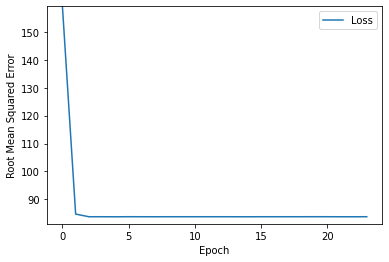

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             134
    4     92             211
    3     69             154
    2     62             132
    3     80             153
    2    295             147
   10    500             456
    5    342             259
    2    118             146
    4    128             221
    8    187             396
    3     80             162
    3    112             179
    4     95             221
    2     69             143


In [17]:
#@title Double-click to view a possible solution to Task 4.

# try median_income
my_feature = "median_income"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)
